<a href="https://colab.research.google.com/github/bahadirbesirkestane/Staj/blob/main/Model_Ornekleri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **ARMA Modelinin Uygulanması**

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('Solarize_Light2')
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
import math
from math import sqrt

>Veri Seti Linki - https://drive.google.com/file/d/1UpO1A-jme40eEqDJeet-iqAEYaB0lhq5/view?usp=drive_link
>
>https://seffaflik.epias.com.tr/transparency/
>
>Veri setinin yüklenemsi

In [13]:
data = pd.read_csv("/content/GercekZamanliTuketim-14092018-14092023.csv")
data.head()

,Tarih,Saat,Tuketim Miktari (MWh)
0,14.09.2018,00:00,"32.113,61"
1,14.09.2018,01:00,"30.843,14"
2,14.09.2018,02:00,"29.869,65"
3,14.09.2018,03:00,"29.201,80"
4,14.09.2018,04:00,"28.610,01"


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43838 entries, 0 to 43837
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Tarih                  43838 non-null  object
 1   Saat                   43838 non-null  object
 2   Tuketim Miktari (MWh)  43838 non-null  object
dtypes: object(3)
memory usage: 1.0+ MB


In [18]:
# veri setinin bir kopyasını oluturup "df" adlı bir değişkene atanması:

df = data.copy()

#tarih kolonunun datetime formatına çevrilmesi:
df['Tarih'] =pd.to_datetime(df['Tarih'] +' '+ df['Saat'], format='%d.%m.%Y %H:%M')

df = df.drop(columns = ["Saat"])
df = df.rename(columns={'Tuketim Miktari (MWh)':'Tuketim'})

In [20]:
# Tuketim değerlerinin sting ten float a çevrilmesi.

df['Tuketim'] = df['Tuketim'].str.replace('.', "" ,regex=True)
df["Tuketim"] = df["Tuketim"].str.replace(',', '.')
df["Tuketim"] = df["Tuketim"].astype(float)

df = df[["Tarih","Tuketim"]]

df.head()

,Tarih,Tuketim
0,2018-09-14 00:00:00,32113.61
1,2018-09-14 01:00:00,30843.14
2,2018-09-14 02:00:00,29869.65
3,2018-09-14 03:00:00,29201.80
4,2018-09-14 04:00:00,28610.01


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43838 entries, 0 to 43837
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Tarih    43838 non-null  datetime64[ns]
 1   Tuketim  43838 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 685.1 KB


>Saatlik frekanstaki veriler Günlük frekansa dönüştürülmesi

In [23]:
data_daily = df.set_index("Tarih").asfreq('D')
data_daily.head()

,Tuketim
Tarih,
2018-09-14,32113.61
2018-09-15,32351.44
2018-09-16,30806.32
2018-09-17,29466.58
2018-09-18,31771.85


In [24]:
data_daily.describe()

,Tuketim
count,1827.000000
mean,33336.217931
std,3580.029978
min,20627.680000
25%,31207.190000
50%,33120.320000
75%,35093.310000
max,45323.420000


>Eksik Veri Kontrolü

In [25]:
data_daily.isnull().sum()

Tuketim    0
dtype: int64

>Yinelenen veri kontrolü

In [26]:
duplicate = data_daily[data_daily.duplicated()]

print("Duplicate Rows :")
duplicate

Duplicate Rows :


,Tuketim
Tarih,
2019-01-06,30573.3


In [27]:
data_daily.drop_duplicates(inplace=True)

>Yinelenen veriler silindikten sonra tekrar kontrol edilir.

In [28]:
duplicate = data_daily[data_daily.duplicated()]

print("Duplicate Rows :")
duplicate

Duplicate Rows :


,Tuketim
Tarih,


>Verilerin çizgi grafiği üzerinde gösteriimi

<Axes: xlabel='Tarih', ylabel='Tuketim'>

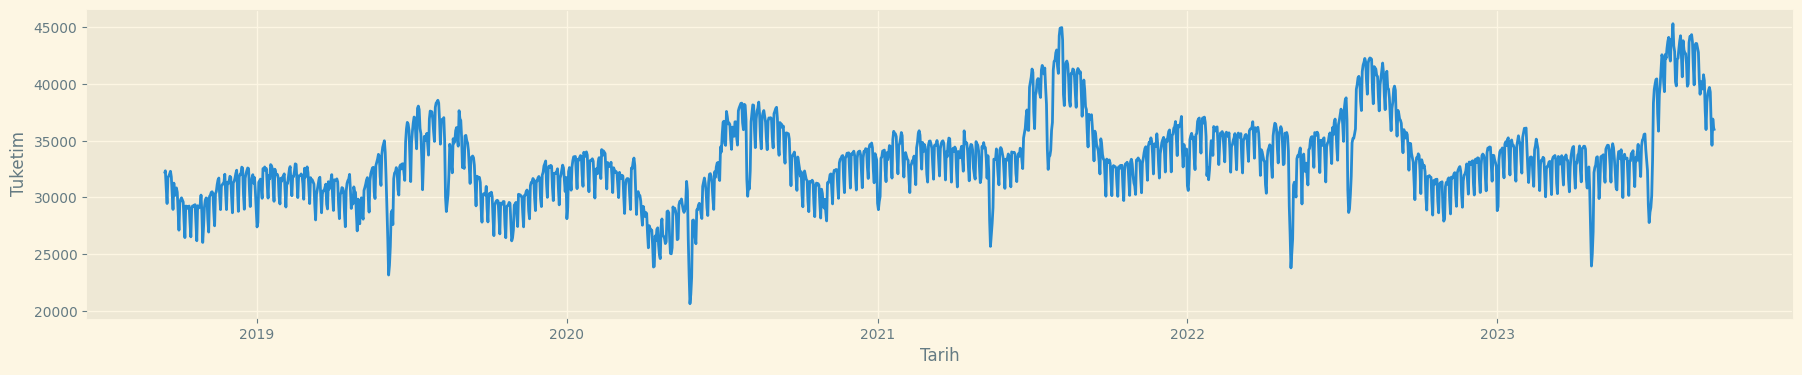

In [29]:
plt.figure(figsize=(22,4))
sns.lineplot(data = data_daily.reset_index(), x="Tarih", y="Tuketim")

>Zaman serisi bileşenleri

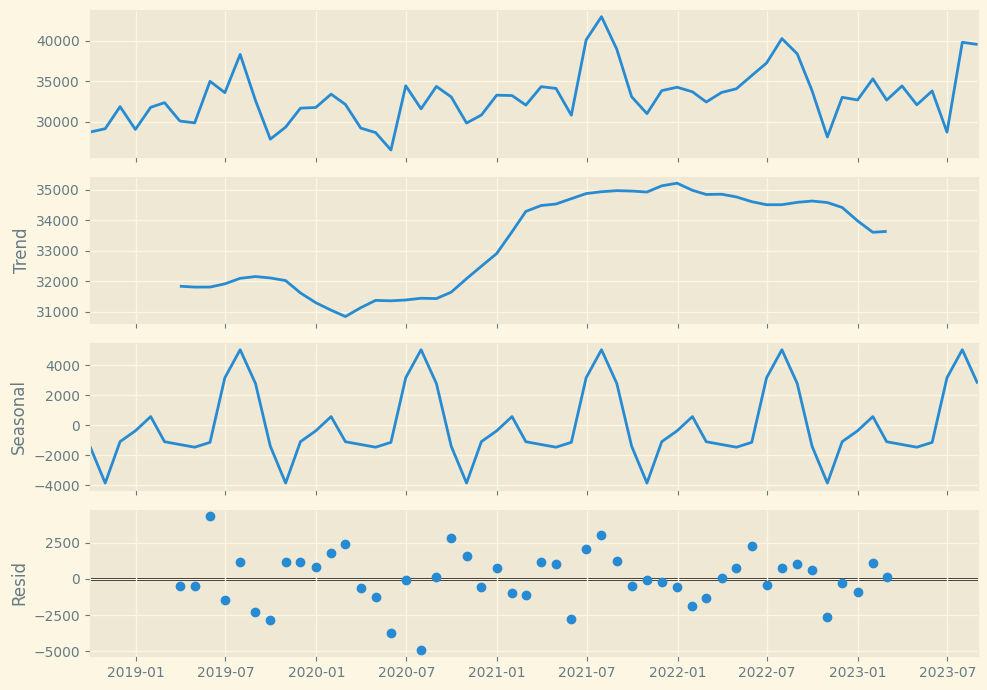

In [34]:
data_monthly = df.set_index("Tarih").asfreq('M')

plt.rcParams['figure.figsize'] = [10,7]
decomposition = sm.tsa.seasonal_decompose(data_monthly)
fig = decomposition.plot()
plt.show()

>ACF-PACF (otokoralasyon ve Kısmi otokoralasyon) grafikleri

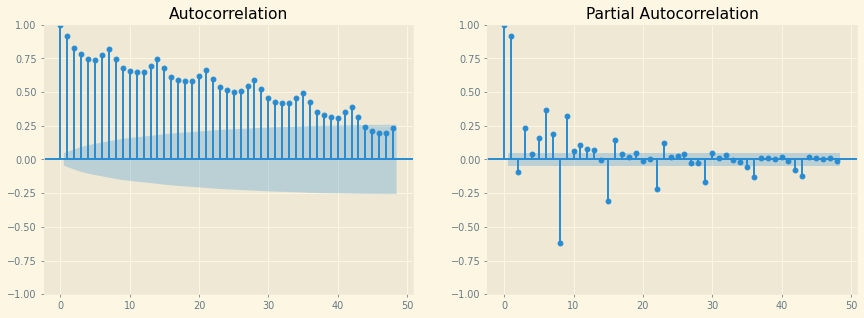

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5), dpi= 70)

plot_acf(data_daily.Tuketim.tolist(), ax=ax1, lags=48)
plot_pacf(data_daily.Tuketim.tolist(), ax=ax2, lags=48, method="ywm")

plt.show()

>Duarağanlık Testleri
>
>ADF Testi (Augmented Dickey-Fuller Test) ve KPSS(Kwiatkowski-Phillips-Schmidt-Shin Test) testi

In [38]:
# ADF Testi:

def adf(data):
    adf_test = sm.tsa.adfuller(data, autolag='AIC')
    print(f'ADF Statistic: {adf_test[0]}')
    print(f'p-value: {adf_test[1]}')
    print("Seri Durağan Değildir") if adf_test[1] > 0.05 else print("Seri Durağandır(Birim Kök Yoktur)")

# KPSS Testi:

def kpss(data):
    kpss_test = sm.tsa.kpss(data)
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print("Seri Durağandır") if kpss_test[1] > 0.05 else print("Seri durağan değildir(Seri Birim Kök İçerir)")

adf(data_daily)
print()
kpss(data_daily)

ADF Statistic: -3.6802517906299115
p-value: 0.004399662725589549
Seri Durağandır(Birim Kök Yoktur)

KPSS Statistic: 1.862249
p-value: 0.010000
Seri durağan değildir(Seri Birim Kök İçerir)


<ipython-input-38-12bf9b6b03d5>:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = sm.tsa.kpss(data)


>ADF testinde birim kök yok, KPSS testinde birim kök var. Buna göre seri fark durağandır fakat yine de fark alınması gerekir.


In [39]:
# Birinci dereceden fark
data_daily_diff = data_daily.copy()
data_daily_diff['Tuketim'] = data_daily['Tuketim'] - data_daily['Tuketim'].shift(1)
data_daily_diff = data_daily_diff.dropna()

>Farkı alınan serinin ACF ve PACF grafikleri:


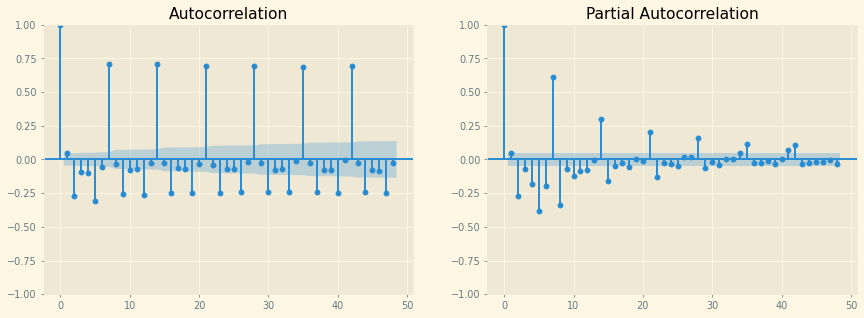

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5), dpi= 70)

plot_acf(data_daily_diff.Tuketim.tolist(), ax=ax1, lags=48)
plot_pacf(data_daily_diff.Tuketim.tolist(), ax=ax2, lags=48, method="ywm")

plt.show()

> Farkı alınan serinin ADF-KPSS testleri:

In [44]:
adf(data_daily_diff)
print()
kpss(data_daily_diff)

ADF Statistic: -10.608287286149514
p-value: 5.924054122434582e-19
Seri Durağandır(Birim Kök Yoktur)

KPSS Statistic: 0.017166
p-value: 0.100000
Seri Durağandır


<ipython-input-38-12bf9b6b03d5>:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = sm.tsa.kpss(data)


> Mevsimsel fark uygulanması:


In [46]:
data_daily_diff2 = data_daily_diff.diff(7).dropna()

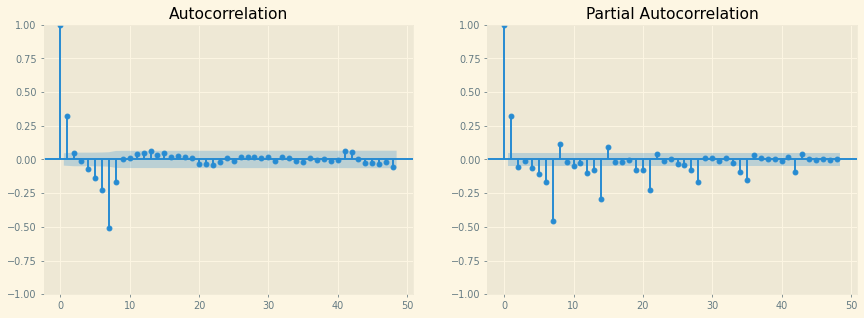

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5), dpi= 70)

plot_acf(data_daily_diff2.Tuketim.tolist(), ax=ax1, lags=48)
plot_pacf(data_daily_diff2.Tuketim.tolist(), ax=ax2, lags=48)

plt.show()

In [49]:
data_daily

,Tuketim
Tarih,
2018-09-14,32113.61
2018-09-15,32351.44
2018-09-16,30806.32
2018-09-17,29466.58
2018-09-18,31771.85
...,...
2023-09-10,36528.47
2023-09-11,34602.26
2023-09-12,36917.80


>Eğitim ve test verisinin dağıtılması.

In [50]:
train_data = data_daily[:'2023-07-31']
test_data = data_daily['2023-08-01':'2023-09-14']
pred_df = test_data.copy()

>ARIMA (2,1,2) uygulanması

<Axes: xlabel='Tarih'>

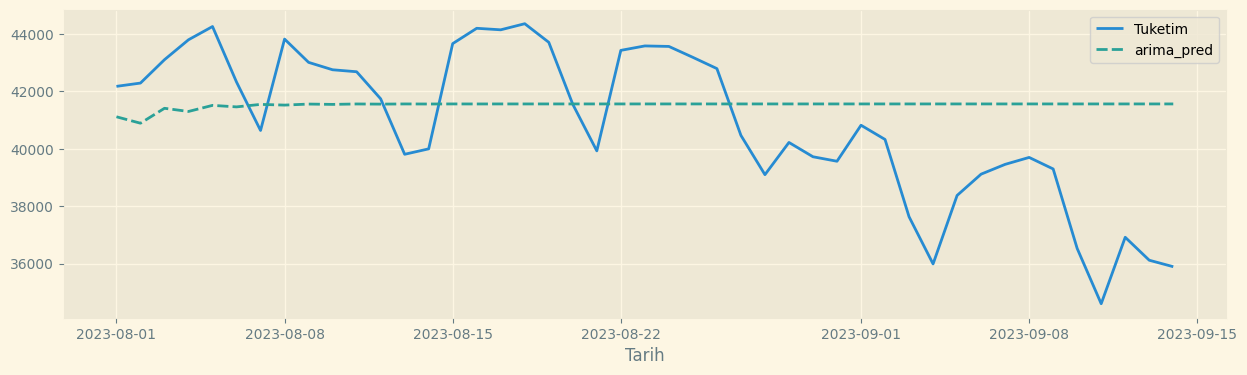

In [54]:
arima_model = sm.tsa.arima.ARIMA(np.asarray(train_data),order=(2,1,2))
arima_model_fit = arima_model.fit()
arima_pred = arima_model_fit.forecast(len(test_data),disp=False)

pred_df["arima_pred"] = arima_pred.round(2)
plt.figure(figsize=(15,4))
sns.lineplot(data = pred_df[['Tuketim', 'arima_pred']])

>SARIMA (2,1,2) (1,1,1,7) uygulanması

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: xlabel='Tarih'>

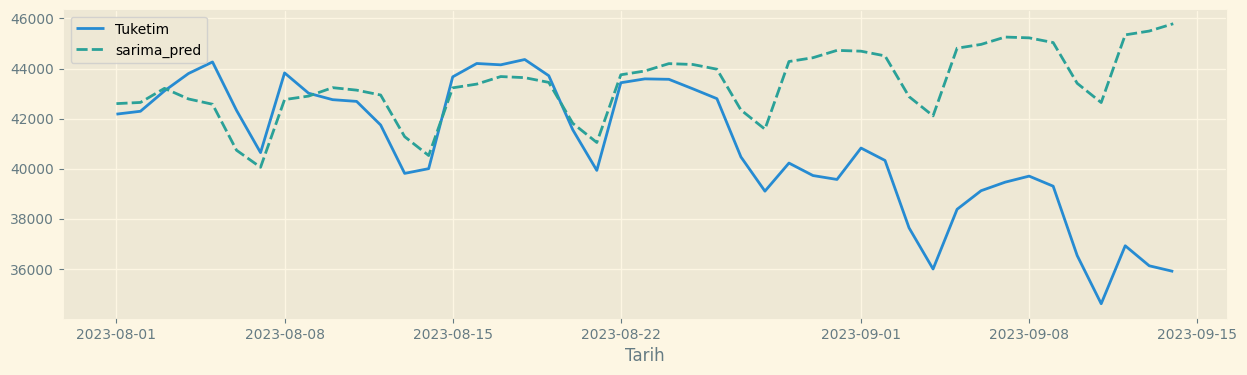

In [56]:
sarima_model = SARIMAX(np.asarray(train_data), order=(2, 1, 2), seasonal_order=(1,1,1,7))
sarima_model_fit = sarima_model.fit()
sarima_pred = sarima_model_fit.forecast(len(test_data))

pred_df["sarima_pred"] = sarima_pred.round(2)
plt.figure(figsize=(15,4))
sns.lineplot(data = pred_df[['Tuketim', 'sarima_pred']])

>Facebook'un geliştirdiği Prophet kütüphanesinde

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfpvdonnw/eyuupgs7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfpvdonnw/89c2p2es.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49576', 'data', 'file=/tmp/tmpfpvdonnw/eyuupgs7.json', 'init=/tmp/tmpfpvdonnw/89c2p2es.json', 'output', 'file=/tmp/tmpfpvdonnw/prophet_model6dt58oaz/prophet_model-20230914131131.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:11:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:11:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


<Axes: xlabel='Tarih'>

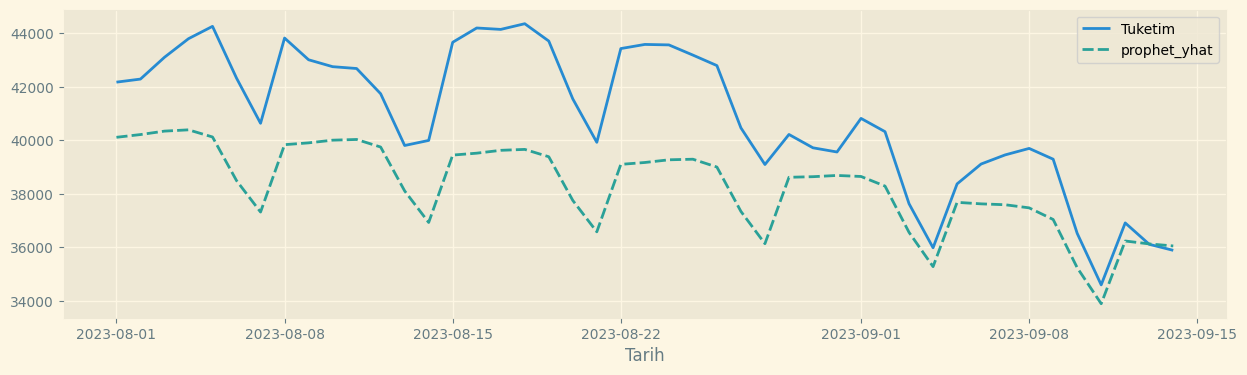

In [59]:
prophet_df = data_daily.reset_index()
prophet_df.columns = ["ds","y"]

train_data_prophet = prophet_df[prophet_df['ds'] < '2023-08-01']
test_data_prophet = prophet_df[(prophet_df['ds'] >= '2023-08-01') & (prophet_df['ds'] <= '2023-09-14')]

prophet_model = Prophet()
prophet_model.fit(train_data_prophet)
model_predict = prophet_model.predict(test_data_prophet)

pred_df["prophet_yhat"] = model_predict["yhat"].values.round(2)
pred_df["prophet_yhat_lower"] = model_predict["yhat_lower"].values.round(2)
pred_df["prophet_yhat_upper"] = model_predict["yhat_upper"].values.round(2)

plt.figure(figsize=(15,4))
sns.lineplot(data = pred_df[['Tuketim', 'prophet_yhat']])

<Axes: xlabel='Tarih'>

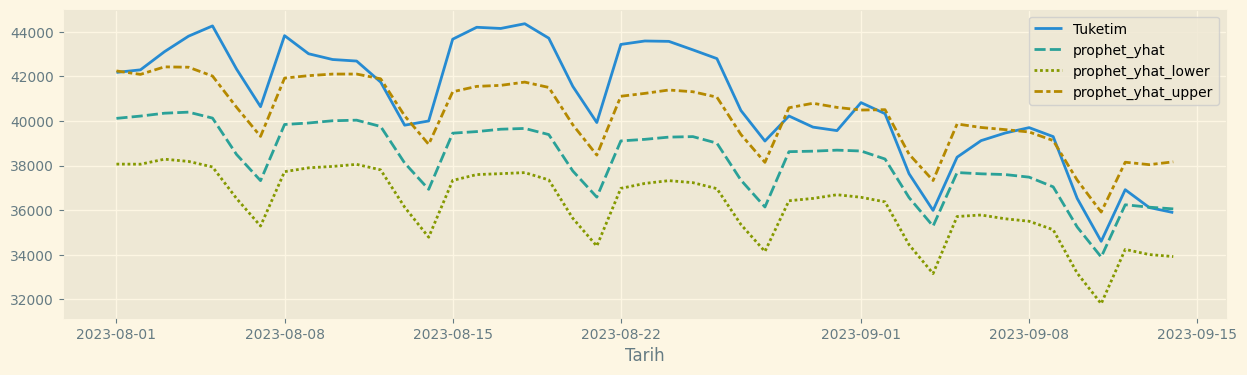

In [61]:
plt.figure(figsize=(15,4))
sns.lineplot(data = pred_df[['Tuketim', 'prophet_yhat', 'prophet_yhat_lower','prophet_yhat_upper']])

In [62]:
prophet_mape = mean_absolute_percentage_error(pred_df["Tuketim"].values, pred_df["prophet_yhat"].values)
prophet_r = r2_score(pred_df["Tuketim"].values, pred_df["prophet_yhat"].values)
prophet_rmse = math.sqrt(mean_squared_error(pred_df["Tuketim"].values, pred_df["prophet_yhat"].values))

arima_mape = mean_absolute_percentage_error(pred_df["Tuketim"].values, pred_df["arima_pred"].values)
arima_r = r2_score(pred_df["Tuketim"].values, pred_df["arima_pred"].values)
arima_rmse = math.sqrt(mean_squared_error(pred_df["Tuketim"].values, pred_df["arima_pred"].values))

sarima_mape = mean_absolute_percentage_error(pred_df["Tuketim"].values, pred_df["sarima_pred"].values)
sarima_r = r2_score(pred_df["Tuketim"].values, pred_df["sarima_pred"].values)
sarima_rmse = math.sqrt(mean_squared_error(pred_df["Tuketim"].values, pred_df["sarima_pred"].values))

results = {'Prophet': [prophet_mape,prophet_rmse,prophet_r],
        'ARIMA': [arima_mape,arima_rmse,arima_r],
        'SARIMA': [sarima_mape,sarima_rmse,sarima_r]}
results = pd.DataFrame(results,index=['MAPE','RMSE','R2'])
results

,Prophet,ARIMA,SARIMA
MAPE,0.062508,0.058122,0.074164
RMSE,2950.033192,2738.580656,4034.177717
R2,-0.251325,-0.078369,-1.340057


**R2 (Coefficient of Determination) :** R Kare, belirleme katsayısıdır. Verilerin fit edilen model tarafından ne kadar iyi açıklandığının bir ölçüsüdür yani bağımlı değişkendeki değişkenliğin ne kadarının model tarafından açıklanabileceğini ölçer ve 0 ile 1 arasında bir değer aldığı varsayılır fakat R Kare negatif değerler de alabilir. R Kare değeri 1'e yaklaştıkça güçlü bir korelasyon var ve algoritmamız iyi, 0'a yaklaştıkça modelimiz ortalamaya yaklaşır ve ilişki azalır.

**RMSE (Root Mean Squared Error):** Kök Ortalama Kare Hata, MSE yani Hata Kareler Ortalamasının kareköküdür. Hata Kareler Ortalaması, tahmin edilen değer ile gerçek değer arasındaki farkların karelerinin ortalamasını temsil eder.

**MAPE (Mean Absolute Percentage Error) :** Ortalama Mutlak Yüzde Hata, tahminlerin mutlak yüzde hatalarının ortalamasıdır.

##**Sonuç**
Bu örnekte ARIMA modelinin R Kare değeri -0.078 olarak negatif bir değer çıkmıştır. Buradan sonuç olarak şunu çıkarabiliriz; Model verilerimiz için uygun değil.